
# Set up the notebook

In [1]:

%pprint

Pretty printing has been turned OFF


In [2]:

import sys

# Insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '../py')

from stats_scraping_utils import StatsScrapingUtilities
from storage import Storage
import matplotlib.pyplot as plt
import textwrap
import seaborn as sns
import numpy as np
import re
from scipy.stats import pearsonr
%matplotlib inline

# Use the following only if you are on a high definition device
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina')

s = Storage()
ssu = StatsScrapingUtilities(s=s)


----


# Prepare the Countries scatterplot

In [3]:

obesity_countries_df = s.load_object('obesity_countries_df')
income_inequality_countries_df = s.load_object('income_inequality_countries_df')


## Clean and prepare Inequality Countries dataset

In [4]:

import pandas as pd

# http://data.un.org/Data.aspx?d=WDI&f=Indicator_Code%3ASI.POV.GINI
url = '../data/csv/gini_index_countries_2016.csv'
income_inequality_countries_df = pd.read_csv(url, encoding=s.encoding_type)
income_inequality_countries_df.columns = ['country_name', 'report_year', 'gini_index', 'footnote_number']
income_inequality_countries_df

,country_name,report_year,gini_index,footnote_number
0,Albania,2016,33.7,1
1,Argentina,2016,42.0,2
2,Armenia,2016,32.5,3
3,Austria,2016,30.8,4
4,Bangladesh,2016,32.4,5
...,...,...,...,...
76,United Kingdom,2016,34.8,4
77,United States,2016,41.1,38
78,Uruguay,2016,39.7,39
79,Vietnam,2016,35.3,40


In [5]:

# Remove country duplicates and misspellings
income_inequality_countries_df.country_name = income_inequality_countries_df.country_name.map(lambda x: ssu.country_name_dict.get(x, x))
all_countries_df = s.load_object('all_countries_df').set_index('country_code', drop=True)
countries_list = sorted(set(income_inequality_countries_df.country_name).symmetric_difference(set(all_countries_df.country_name)))
print(countries_list)
doubles_df = ssu.check_4_doubles(countries_list)
mask_series = (doubles_df.max_similarity > 0.6)
columns_list = ['first_item', 'second_item', 'max_similarity']
if doubles_df[mask_series].shape[0]:
    display(doubles_df[mask_series][columns_list].sort_values('max_similarity', ascending=False))
mask_series = income_inequality_countries_df.duplicated(subset=['country_name'], keep=False)
if income_inequality_countries_df[mask_series].shape[0]:
    display(income_inequality_countries_df[mask_series])

['Afghanistan', 'Algeria', 'American Samoa', 'Andorra', 'Angola', 'Anguilla', 'Antarctica', 'Antigua & Barbuda', 'Aruba', 'Australia', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Barbados', 'Belize', 'Benin', 'Bermuda', 'Bhutan', 'Bonaire, Sint Eustatius & Saba', 'Bosnia & Herzegovina', 'Botswana', 'Bouvet Island', 'British Indian Ocean Territory', 'British Virgin Islands', 'Brunei', 'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon', 'Cayman Islands', 'Central African Republic', 'Chad', 'Chile', 'Christmas Island', 'Cocos (Keeling) Islands', 'Comoros', 'Cook Islands', 'Cuba', 'Curaçao', "Côte d'Ivoire", 'DRC', 'Djibouti', 'Dominica', 'Egypt', 'Equatorial Guinea', 'Eritrea', 'Ethiopia', 'Falkland Islands (Malvinas)', 'Faroe Islands', 'Federated States of Micronesia', 'Fiji', 'French Guiana', 'French Polynesia', 'French Southern Territories', 'Gabon', 'Gambia', 'Gibraltar', 'Greenland', 'Grenada', 'Guadeloupe', 'Guam', 'Guatemala', 'Guernsey', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Hear

,first_item,second_item,max_similarity
55,Gambia,Zambia,0.833333
109,Niger,Nigeria,0.833333
113,North Korea,South Korea,0.818182
116,Pakistan,Tajikistan,0.777778
103,Namibia,Zambia,0.769231
36,Cook Islands,Norfolk Island,0.769231
23,British Virgin Islands,US Virgin Islands,0.769231
24,Brunei,Burundi,0.769231
57,Greenland,Grenada,0.750000
29,Cayman Islands,Åland Islands,0.740741



## Create the Countries scatterplot

In [29]:

# Explanatory variable
xname = 'gini_index'

# Response variable
yname = 'obesity_rate_2016'

# Remove NaNs
columns_list = ['country_name', xname, yname]
df = obesity_countries_df.merge(income_inequality_countries_df, on='country_name', how='inner')[columns_list].dropna()
xdata = df[xname]
ydata = df[yname]

In [7]:

df.sample(5)

,country_name,gini_index,obesity_rate_2016
23,Latvia,34.3,23.6
26,Poland,31.2,23.1
54,Bolivia,45.3,20.2
34,Finland,27.1,22.2
5,Argentina,42.0,28.3


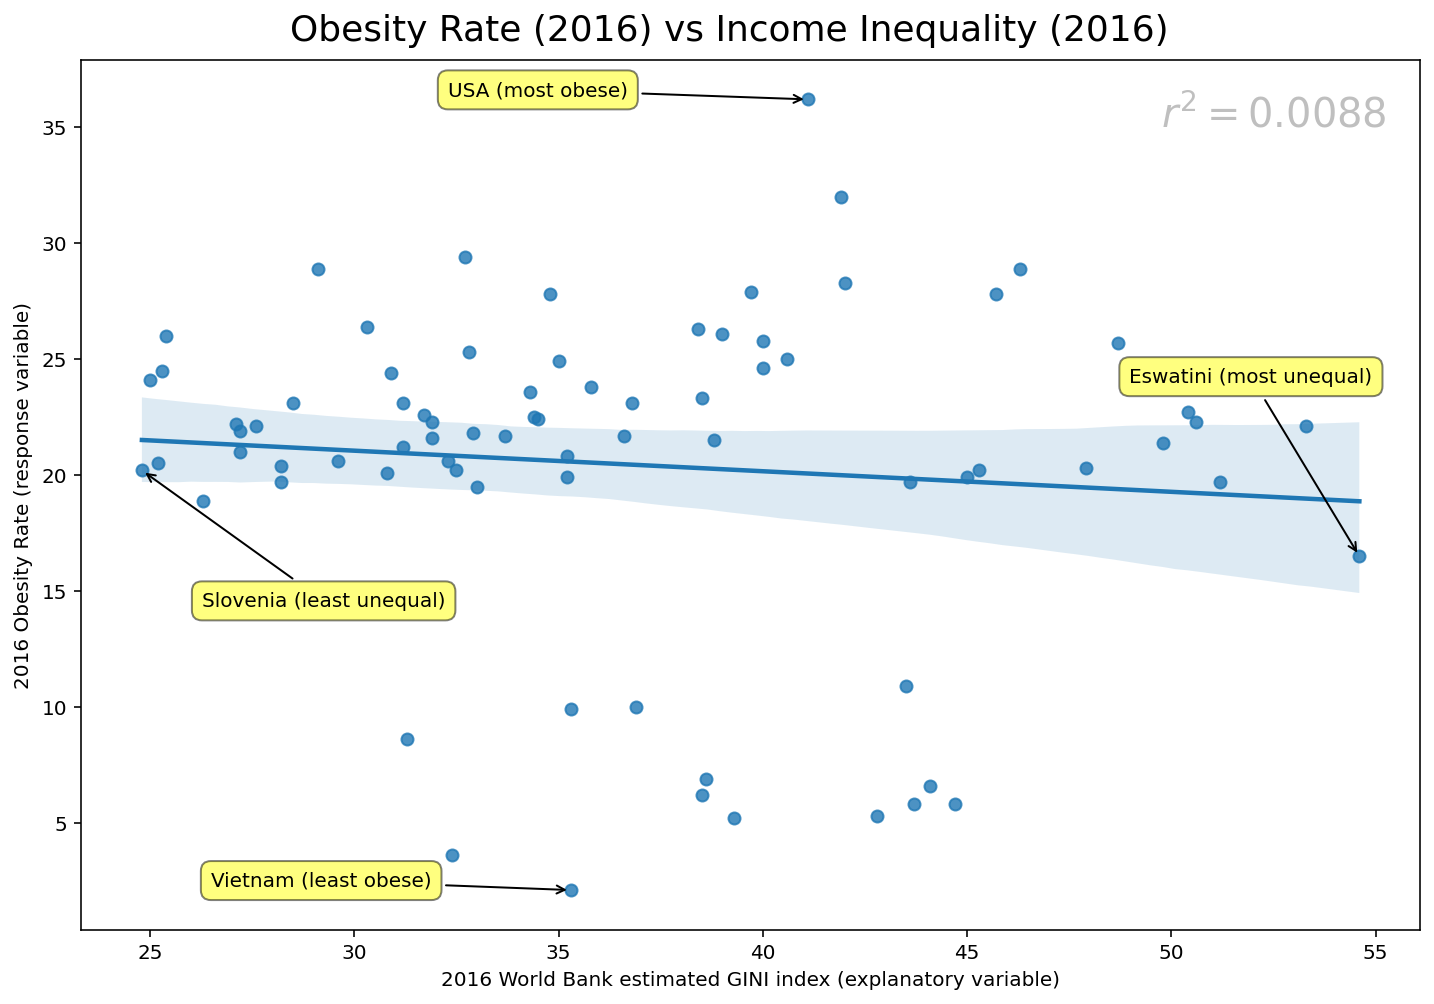

In [31]:

# First order (linear) scatterplot
fig = plt.figure(figsize=(12,8))
merge_axes_subplot = sns.regplot(x=xname, y=yname, scatter=True, data=df)
xlabel_str = '2016 World Bank estimated GINI index (explanatory variable)'
xlabel_text = plt.xlabel(xlabel_str)
ylabel_str = '2016 Obesity Rate (response variable)'
ylabel_text = plt.ylabel(ylabel_str)
kwargs = dict(textcoords='offset points', ha='left', va='bottom',
              bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
              arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
least_unequal = xdata.min()
most_unequal = xdata.max()
most_obese = ydata.max()
least_obese = ydata.min()
for label, x, y in zip(df['country_name'], xdata, ydata):
    if (x == least_unequal):
        annotation = plt.annotate('{} (least unequal)'.format(label),
                                  xy=(x, y), xytext=(30, -70), **kwargs)
    elif (x == most_unequal):
        annotation = plt.annotate('{} (most unequal)'.format(label),
                                  xy=(x, y), xytext=(-115, 85), **kwargs)
    elif (y == most_obese):
        annotation = plt.annotate('{} (most obese)'.format(label),
                                  xy=(x, y), xytext=(-180, 0), **kwargs)
    elif (y == least_obese):
        annotation = plt.annotate('{} (least obese)'.format(label),
                                  xy=(x, y), xytext=(-180, 0), **kwargs)
    elif (label == 'USA'):
        annotation = plt.annotate('{} (most evil)'.format(label),
                                  xy=(x, y), xytext=(-75, 25), **kwargs)
# Add r-squared
plt.text(52.5, 35.5, r'$r^2 = {0:.2}$'.format(pearsonr(xdata, ydata)[0] ** 2), fontsize=20, alpha=0.25,
         horizontalalignment='center', verticalalignment='center')

title_str = 'Obesity Rate (2016) vs Income Inequality (2016)'
title_obj = fig.suptitle(title_str, fontsize=18, y=0.92)